In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import alex_cifar10

branchyNet = alex_cifar10.get_network()
branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import mnist, pcifar10
x_train, y_train, x_test, y_test = pcifar10.get_data()

Settings

In [5]:
TRAIN_BATCHSIZE = 512
TEST_BATCHSIZE = 128
TRAIN_NUM_EPOCHS = 50

Train Main Network

In [ ]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

Train BranchyNet

In [ ]:
TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                                   num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

In [ ]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

In [ ]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Get exit result, compute openmax vs softmax

In [1]:
import dill
with open("_models/alexnet_cifar10.bn", "rb") as f:
    branchyNet = dill.load(f)

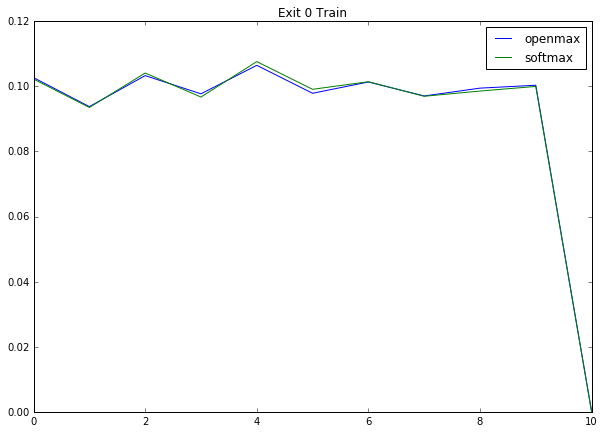

[ 0.10265532  0.0937594   0.10328107  0.09768827  0.10644251  0.09785724
  0.10132059  0.09703202  0.09943661  0.10032709  0.00019987]
[ 0.10221956  0.09349772  0.10407394  0.09670094  0.10759072  0.09907273
  0.10140614  0.09693923  0.09854002  0.09995899  0.        ]


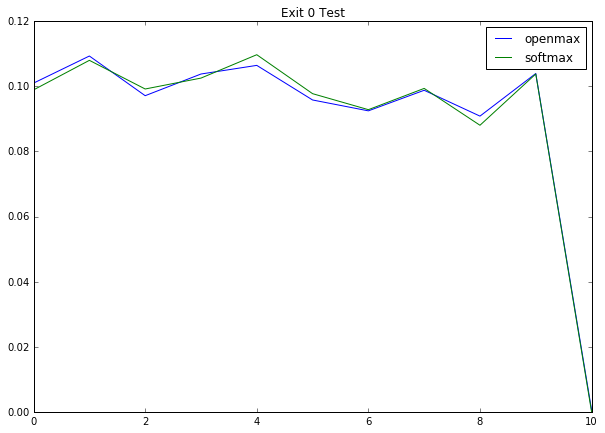

[ 0.10098489  0.10930273  0.09711419  0.10377402  0.10642782  0.09579772
  0.09245771  0.09877913  0.09083982  0.10393164  0.00059034]
[ 0.09890112  0.10797507  0.09917224  0.10252251  0.10970305  0.09773609
  0.09282003  0.09935407  0.08803098  0.10378485  0.        ]


In [15]:
import scipy as sp

branchyNet.testing()
branchyNet.to_cpu()

from openmax.openmax import OpenMax, get_openmax_scores, plot_openmax_mean

size = 5000

for i, model in enumerate(branchyNet.models):
    features_train = sp.expand_dims(model.test(x_train[:size]).data,1)
    features_test = sp.expand_dims(model.test(x_test[:size]).data,1)
    
    openmax = OpenMax()
    openmax.fit(features_train)

    openmax_vs_train, softmax_vs_train = get_openmax_scores(features_train, openmax)
    openmax_vs_test, softmax_vs_test = get_openmax_scores(features_test, openmax)
    
    plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit {} Train'.format(i))
    plot_openmax_mean(openmax_vs_test, softmax_vs_test, title='Exit {} Test'.format(i))
    break

In [7]:
import scipy as sp
data = sp.expand_dims(branchyNet.models[0].test(x_test[:5000]).data,1)

AttributeError: 'numpy.ndarray' object has no attribute 'shpae'

In [21]:
import matplotlib.pyplot as plt
import numpy as np
idxs = np.argsort(sp.stats.entropy(softmax_vs_train.T))[4000:]

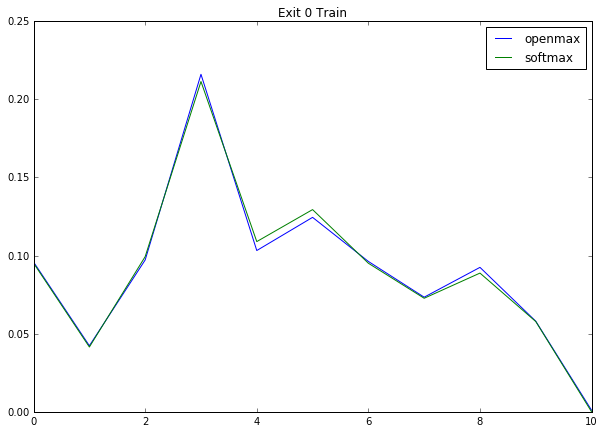

[ 0.09583744  0.04228097  0.09718019  0.21601705  0.10322019  0.12445561
  0.09623155  0.07335882  0.09244595  0.0579735   0.00099872]
[ 0.0951281   0.04147079  0.0993225   0.21140236  0.10893984  0.1294222
  0.09508371  0.07267091  0.08878431  0.05777526  0.        ]


In [24]:
#plot_openmax_mean(openmax_vs_test, softmax_vs_test, title='Exit {} Test'.format(i))
#openmax_vs_train, softmax_vs_train = get_openmax_scores(features_train[idxs], openmax)
#plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit {} Train'.format(i))


In [29]:
x_train.shape

(50000L, 3L, 32L, 32L)

In [34]:
x_fake = (np.random.random((100, 3, 32, 32))*10) - 5

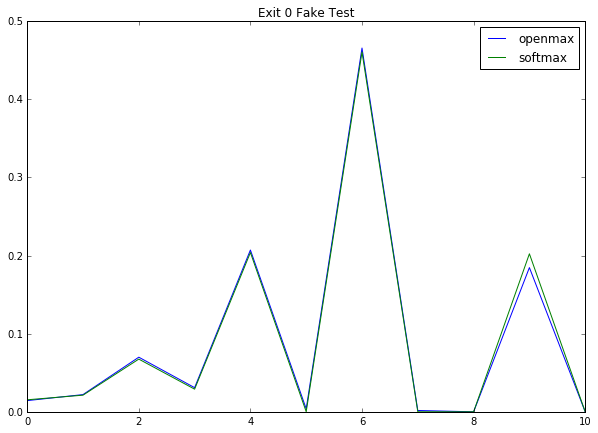

[  1.43159994e-02   2.20298672e-02   6.99097079e-02   3.09072757e-02
   2.07093589e-01   3.83131635e-03   4.65652102e-01   1.67353182e-03
   3.64277650e-13   1.84586610e-01   3.90821604e-10]
[  1.53590510e-02   2.12863395e-02   6.74465927e-02   2.90010975e-02
   2.03877476e-01   1.46525884e-04   4.60614222e-01   1.32209836e-06
   5.10586947e-16   2.02267377e-01   0.00000000e+00]


In [48]:
features_train = sp.expand_dims(model.test(x_fake.astype(np.float32)).data,1)
openmax_vs_train, softmax_vs_train = get_openmax_scores(features_train, openmax)
    
plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit {} Fake Test'.format(i))
